In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "skin-cancer-data"

In [31]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

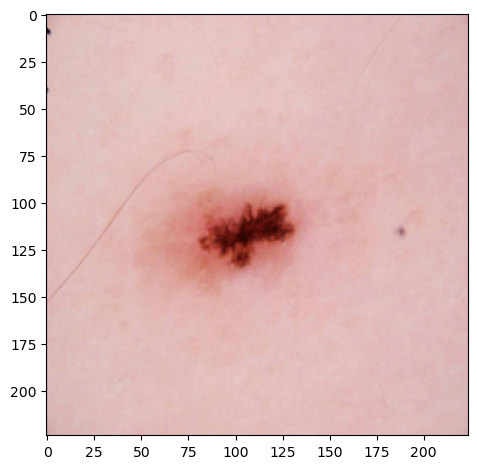

In [32]:
import matplotlib.image as mpimg
test_image = "skin-cancer-data/benign/1.jpg"
img = mpimg.imread(test_image)
plt.imshow(img)
save_fig("sample_benign_image")

In [4]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

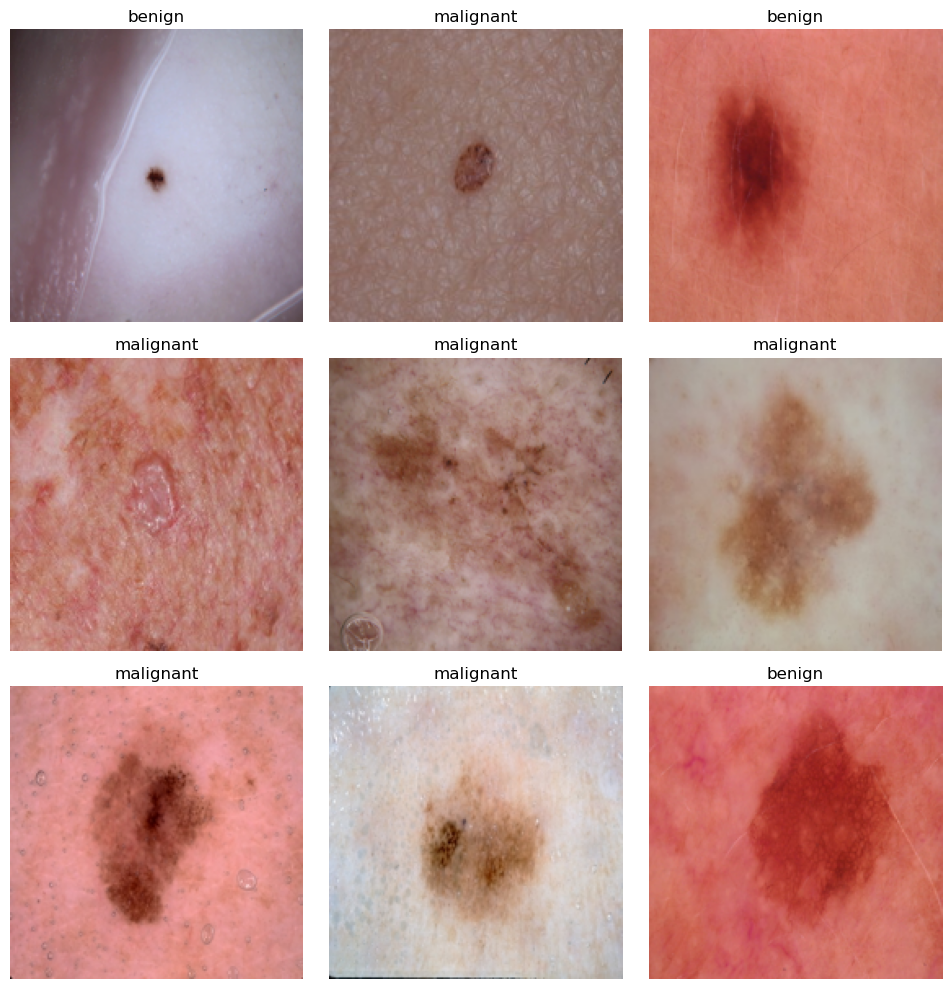

In [33]:
# Here are the first nine images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_images")

In [9]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standardize values to be in the [0, 1] RGB channel range by using tf.keras.Rescalling
normalization_layers = layers.Rescaling(1./255)

In [12]:
# Reduce overfitting though data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height, 
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

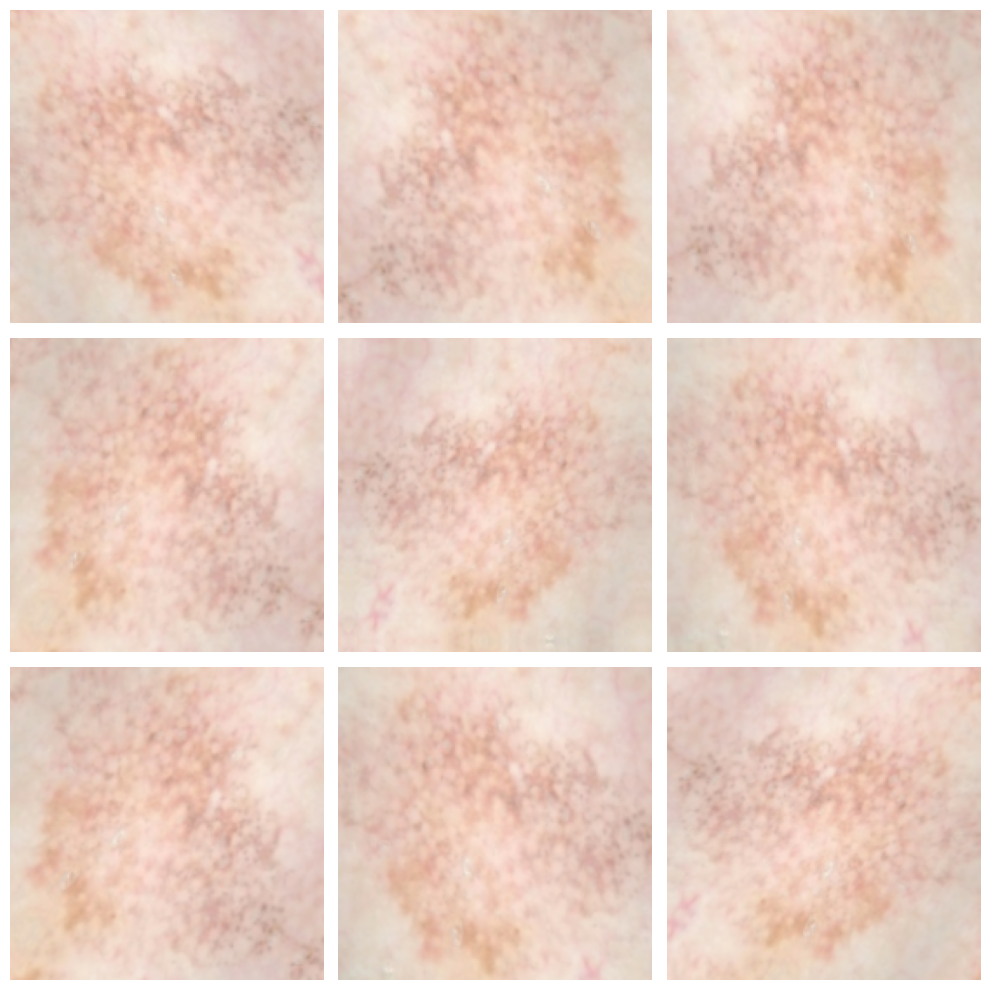

In [34]:
# visualize a few augmentade examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')
        save_fig("sample_augmented_images")

In [14]:
# introduce Dropout to the network to help reduce overfitting
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [15]:
# compile and train the model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [17]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15
83/83 [==============================] - 122s 1s/step - loss: 0.6854 - accuracy: 0.6069 - val_loss: 0.5041 - val_accuracy: 0.7891
Epoch 2/15
83/83 [==============================] - 105s 1s/step - loss: 0.4861 - accuracy: 0.7672 - val_loss: 0.4598 - val_accuracy: 0.7557
Epoch 3/15
83/83 [==============================] - 113s 1s/step - loss: 0.4384 - accuracy: 0.7892 - val_loss: 0.5243 - val_accuracy: 0.7405
Epoch 4/15
83/83 [==============================] - 114s 1s/step - loss: 0.4037 - accuracy: 0.8097 - val_loss: 0.4360 - val_accuracy: 0.7906
Epoch 5/15
83/83 [==============================] - 111s 1s/step - loss: 0.3890 - accuracy: 0.8086 - val_loss: 0.4421 - val_accuracy: 0.7876
Epoch 6/15
83/83 [==============================] - 112s 1s/step - loss: 0.3940 - accuracy: 0.8048 - val_loss: 0.4403 - val_accuracy: 0.7769
Epoch 7/15
83/83 [==============================] - 112s 1s/step - loss: 0.4071 - accuracy: 0.8059 - val_loss: 0.4030 - val_accuracy: 0.8027
Epoch 8/15
83

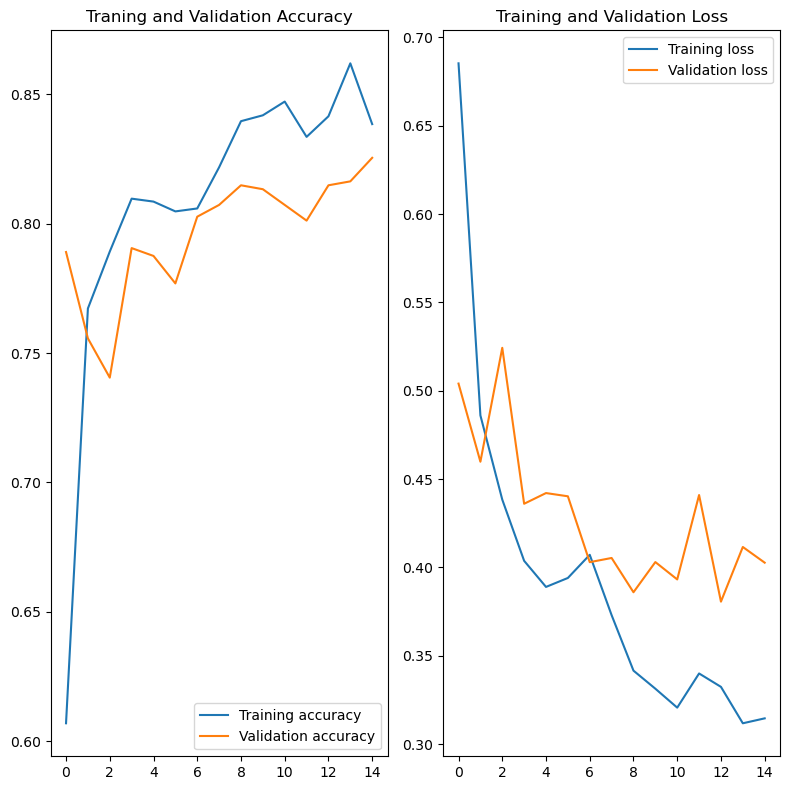

In [35]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
save_fig("training_and_validation_accuracy_and_loss")
plt.show()

In [19]:
# predict on new data
img = tf.keras.utils.load_img(
    "skin-cancer-data/bening1.jpg", target_size= (img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 225ms/step
This image most likely belongs to benign with a 99.94 percent confidence.


In [20]:
# convert the model to tensorflow lite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save the model
with open('skin_cancer_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpimh7k1ky\assets


INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpimh7k1ky\assets


In [21]:
# run the tensorflow lite model

TF_MODEL_FILE_PATH = 'skin_cancer_model.tflite'
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [22]:
# # Print signatures from the converted model to get the names of the inputs and outputs

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In [23]:
# # test the loaded model

classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [25]:
# # make predictions using the tensorflow lite model

predictions_lite = classify_lite(sequential_input = img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [26]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to benign with a 99.94 percent confidence.


In [27]:
print(np.max(np.abs(predictions - predictions_lite)))

1.4305115e-06


In [28]:
import os
import json
import requests
import tempfile

In [29]:
MODEL_DIR = "ML/models/skin_cancer_model"
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print("\nextport_path = {}".format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/skin_cancer_model\1\assets


INFO:tensorflow:Assets written to: ML/models/skin_cancer_model\1\assets



extport_path = ML/models/skin_cancer_model\1


Invalid switch - "models".


In [30]:
model.save("skin_cancer_classifier.h5")